# Import Libs

In [1]:
import tensorflow as tf ### models
import matplotlib.pylab as plt ### ploting
import seaborn as sns
import numpy as np ### math computations
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Input, Layer,Dropout,
                                     RandomFlip, RandomRotation, Resizing, Rescaling #for augmentation
                                     )
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (BinaryAccuracy,
                                      binary_accuracy, # As method
                                      TruePositives,
                                      FalsePositives,
                                      FalseNegatives,
                                      TrueNegatives,
                                      Precision,
                                      Recall,
                                      AUC)
from sklearn.metrics import confusion_matrix, roc_curve,f1_score

from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

import cv2
import albumentations as A

In [2]:
tf.__version__

'2.15.0'

# Load Malaria Dataset

In [3]:
dataset, dataset_info = tfds.load('malaria',with_info=True, as_supervised=True, shuffle_files = True, split = 'train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompletePC41P8/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
tfds.__version__

'4.9.4'

# Data Split

In [5]:
TRANI_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRANI_RATIO*DATASET_SIZE))
    val_test__dataset = dataset.skip(int(TRANI_RATIO*DATASET_SIZE))
    val_dataset = val_test__dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test__dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset


In [7]:
#dataset = tf.data.Dataset.range(20)
train_dataset, val_dataset, test_dataset = splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO)

# Data Visualizing

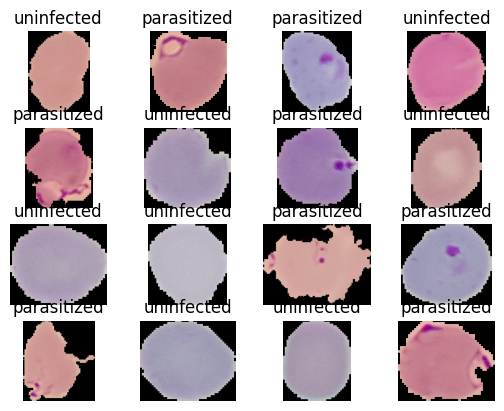

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [9]:
 dataset_info.features['label'].int2str(0)

'parasitized'

# Augmentation

In [10]:
IM_SIZE = 224

## Albumentations

In [11]:
transforms = A.Compose([
            A.Resize(IM_SIZE, IM_SIZE),
            A.OneOf([A.HorizontalFlip(),
                     A.VerticalFlip()]),
            A.RandomRotate90(),
            #A.RandomGridShuffle(grid=(3,3), always_apply=False, p = 0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, always_apply=False, p = 0.5),
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0),  always_apply=False, p = 0.5)

        ])

In [12]:
def aug_albument(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return aug_img

In [13]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

# Data Preprocessing

In [14]:
BATCH_SIZE = 32
train_dataset = (train_dataset
                 .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                 .map(process_data) # augmentation with Albumentation
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset
               .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                .map(process_data) # augmentation with Albumentation
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))

#test_dataset = test_dataset.map(resizing_rescaling_layers)

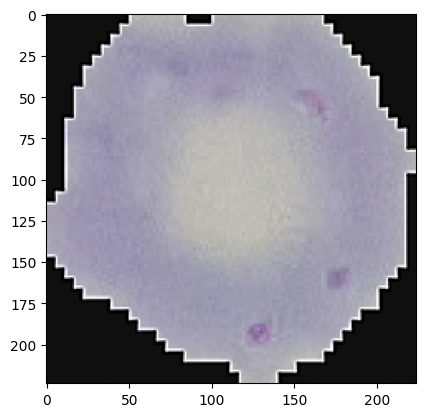

In [15]:
im, lbl = next(iter(train_dataset))
plt.imshow(im[0])

In [16]:
im.shape

TensorShape([32, 224, 224, 3])

In [17]:
lbl.shape

TensorShape([32])

In [18]:
lbl

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1])>

In [19]:
lbl2 = tf.zeros_like(lbl)
lbl2

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [20]:
binary_accuracy(lbl, lbl2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.46875>

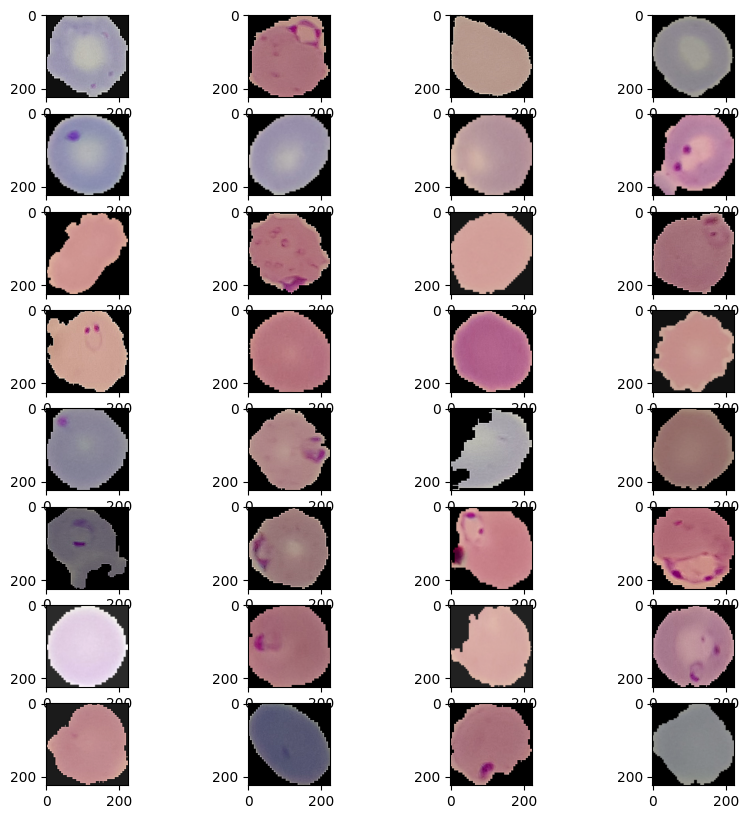

In [21]:
plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(8, 4, i+1)
    plt.imshow(im[i])

# BuildModel

In [22]:
sequential_model = tf.keras.Sequential([
    InputLayer(input_shape= (IM_SIZE, IM_SIZE,3)),

    Conv2D(filters= 8,kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),

    Conv2D(filters= 16,kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),

    Dense(units=100, activation='relu'),
    BatchNormalization(),

    Dense(units=10, activation='relu'),
    BatchNormalization(),

    Dense(units=1, activation='sigmoid')
])
sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

# Custom Metric

## Custom Metric Method (Without parameters)

In [23]:
def custom_accuracy(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)

## Custom Metric Method (With parameters)

In [24]:
def custom_accuracy(FACTOR = 1):
    def metric(y_true, y_pred):
        return binary_accuracy(y_true, y_pred)*FACTOR
    return metric

## Custom Metric Class

In [25]:
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name = 'Custom_Accuracy', FACTOR = 1):
        super(CustomAccuracy, self).__init__()
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name = name, initializer = 'zeros')
    def update_state(self, y_true, y_pred, sample_weight = None):
        output = binary_accuracy(tf.cast(y_true, dtype = tf.float32), y_pred)*self.FACTOR
        self.accuracy.assign(tf.math.count_nonzero(output, dtype = tf.float32)/tf.cast(len(output), dtype = tf.float32))
    def result(self):
        return self.accuracy
    def reset_state(self):
        self.accuracy.assign(0.)

# Metrics

In [26]:
metrics = [TruePositives(name='tp'),
           FalsePositives(name= 'fp'),
           FalseNegatives(name= 'fn'),
           TrueNegatives(name='tn'),
           #BinaryAccuracy(name='accuracy'), # Buildin Binary Accuracy
           #custom_accuracy, # Without parameters
           #custom_accuracy(FACTOR = 2.0), # Without parameters
           CustomAccuracy(),
           Precision(name='precision'),
           Recall(name='recall'),
           AUC(name='auc')]

# Custom Loss

## Custom Loss Method (Without parameters)

In [27]:
def custom_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)

## Custom Loss Method (With parameters)

In [28]:
def custom_bce(FACTOR = 1):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred)*FACTOR
    return loss

# Custom Loss Class

In [29]:
class CustomBCE(tf.keras.losses.Loss):
    def __init__(self, FACTOR):
        super(CustomBCE, self).__init__()
        self.FACTOR = FACTOR
    def call(self, y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred)*self.FACTOR

# Compile

In [30]:
sequential_model.compile(
    optimizer=Adam(learning_rate=0.1),
    #loss=custom_bce,   # custom Binary Cross entropy without parameter
   # loss=custom_bce(FACTOR = 2.0), # custom Binary Cross entropy with parameter
    loss=CustomBCE(FACTOR = 1.0), # custom Loss Class
    metrics= metrics,)

# Train

In [31]:
history = sequential_model.fit(train_dataset, validation_data=val_dataset, epochs=2, verbose=1)

Epoch 1/2
689/689 [==============================] - 142s 181ms/step - loss: 0.5252 - tp: 8169.0000 - fp: 3181.0000 - fn: 2857.0000 - tn: 7839.0000 - custom_accuracy: 0.9333 - precision: 0.7197 - recall: 0.7409 - auc: 0.8141 - val_loss: 5.7162 - val_tp: 1383.0000 - val_fp: 1296.0000 - val_fn: 13.0000 - val_tn: 63.0000 - val_custom_accuracy: 0.6667 - val_precision: 0.5162 - val_recall: 0.9907 - val_auc: 0.5346
Epoch 2/2
689/689 [==============================] - 104s 151ms/step - loss: 0.2752 - tp: 10393.0000 - fp: 1393.0000 - fn: 629.0000 - tn: 9631.0000 - custom_accuracy: 0.9667 - precision: 0.8818 - recall: 0.9429 - auc: 0.9436 - val_loss: 2.2574 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_fn: 1384.0000 - val_tn: 1369.0000 - val_custom_accuracy: 0.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1858


# Loss

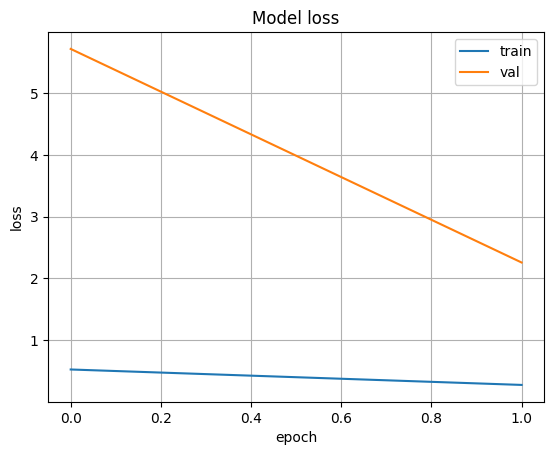

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.grid(True)
plt.show()

# Performance

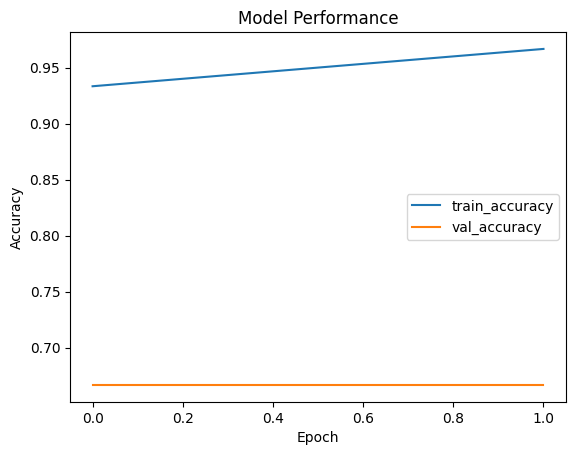

In [33]:
plt.plot(history.history['custom_accuracy'])
plt.plot(history.history['val_custom_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [34]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,label

In [35]:
test_dataset2 = test_dataset.map(resize_rescale).batch(1)

In [36]:
evals = sequential_model.evaluate(test_dataset2, return_dict = True)
evals

2757/2757 [==============================] - 25s 5ms/step - loss: 2.2163 - tp: 0.0000e+00 - fp: 1.0000 - fn: 1365.0000 - tn: 1391.0000 - custom_accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.1766


{'loss': 2.2163350582122803,
 'tp': 0.0,
 'fp': 1.0,
 'fn': 1365.0,
 'tn': 1391.0,
 'custom_accuracy': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'auc': 0.1765964925289154}

# Predict

In [37]:
sequential_model.predict(test_dataset2.take(1))[0][0]

1/1 [==============================] - 12s 12s/step


0.02743059

In [38]:
def parasite_or_not(x):
    if x<0.5:
        return str('P')
    else:
        return str('U')

In [39]:
parasite_or_not(sequential_model.predict(test_dataset2.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'P'

1/1 [==============================] - 0s 17ms/step


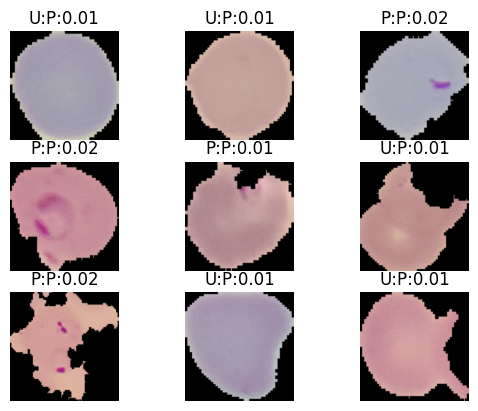

In [40]:
for i, (image, label) in enumerate(test_dataset2.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  res = sequential_model.predict(image)[0][0]
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(res)) + ":"+ str(round(res, 2)))
  plt.axis('off')

In [41]:
test_dataset2.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Visualising Confusion Matrix

In [42]:
inps = []
labels = []
for _,(x,y) in enumerate(test_dataset2):
    labels.append(y)
    inps.append(x)

In [43]:
labels[:5]

[<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>]

In [44]:
labels = np.array([i.numpy()[0] for i in labels])
print(labels)

[1 0 1 ... 1 0 0]


In [45]:
np.array(inps[0]).shape

(1, 224, 224, 3)

In [46]:
predicted = [sequential_model.predict(i) for i in inps ] #np.array(inps)[:,0,...])
len(predicted)

1/1 [==============================] - 0s 22ms/step


2757

In [47]:
pred_labels = np.squeeze(predicted)
pred_labels.shape

(2757,)

In [48]:
threshold = 0.5

cm = confusion_matrix(labels, pred_labels > threshold)
print(cm)

[[1397    1]
 [1359    0]]


Text(0.5, 58.7222222222222, 'Predicted')

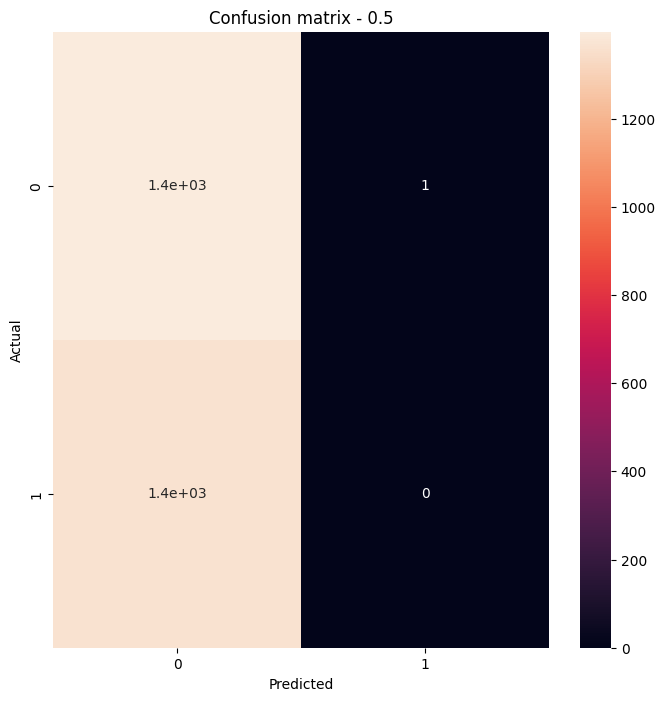

In [49]:
plt.figure(figsize = (8, 8))
sns.heatmap(cm , annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Plots

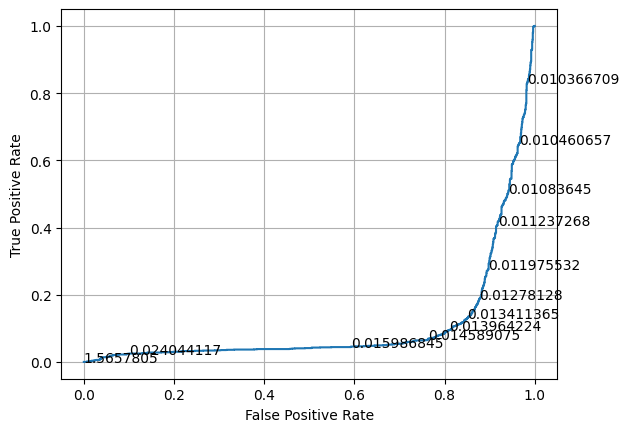

In [50]:
fp, tp ,threshoulds = roc_curve(labels, pred_labels)
plt.plot(fp, tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 50

for i in range(0, len(threshoulds), skip):
    plt.text(fp[i], tp[i], threshoulds[i])
plt.show()

In [51]:
f1 = f1_score(y_true= labels, y_pred= np.round(pred_labels))
f1

0.0